In [20]:
import torch
import torchvision
import os

import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
#import tensorflow as tf
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.optim.lr_scheduler import ExponentialLR

from transformers import BeitForImageClassification, BeitConfig, BeitFeatureExtractor, Trainer, TrainingArguments
from AutoAugment.autoaugment import ImageNetPolicy
# from AutoAugment.ops import *

# from autoaugment import ImageNetPolicy

from PIL import Image

from tqdm import tqdm
from collections import defaultdict, OrderedDict

In [2]:
# Check for GPU
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cuda:0'

In [3]:
df = pd.read_csv("./AML_project/data/train_labels.csv", names=['img_name', 'label'], header=1)

df = df.append([df[df["label"] == 20]] * 15, ignore_index = True)
df = df.sample(frac=1).reset_index(drop=True)

df.shape

(31016, 2)

In [4]:
class food_set(Dataset):

    def __init__(self, labels_file, img_dir, transform = None, settype = "train"):
        if settype == "train":
            self.img_labels = df[:28000]
        elif settype == "val":
            self.img_labels = df[28000:]
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
                   
        label = self.img_labels.iloc[idx, 1]       
            
        return image, label

In [5]:
class food_test(Dataset):

    def __init__(self, img_dir, transform = None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)
        
        return file_name, features

In [6]:
# Load BEiT
model = models.densenet161(pretrained=True)

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2208, 1104)),
                          ('relu', nn.ReLU()),
                          ("dropout", nn.Dropout(0.1)),
                          ('fc2', nn.Linear(1104, 81)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier
model = model.to(device)

In [7]:
# PATH = './transfered_beit.pth'
# torch.save(beit.state_dict(), PATH)

In [14]:
def train_loop(trainloader, valloader, model, criterion, optimizer, scheduler = None):
    
    # Train on GPU if available
    model = model.to(device)
    model.train()
    
    # Metadata
    stats = defaultdict(list)
    current_acc = 0
    max_acc = 0
    
    try:
        stats["epoch"].append(0)
        stats["loss"].append(8.7)
        stats["accuracy"].append(1.25)

        for epoch in range(5):
            size = len(trainloader.dataset)

            for batch, (image, label) in enumerate(trainloader):
                # Compute prediction and loss
                image, label = image.to(device), label.to(device)            
                pred = model(image)
                loss = criterion(pred, label)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Print progress
                if batch % 200 == 0:
                    loss, current = loss.item(), batch * len(image)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch + 1}")

            # Print performance after current number of epochs
            print(f"Epoch: {epoch + 1}")
            current_acc, avg_loss = test_loop(valloader, model, criterion)

            if current_acc > max_acc:
                PATH = f'./beiter.pth'
                torch.save(model.state_dict(), PATH)
                max_acc = current_acc

            # Store metadata
            stats["epoch"].append(epoch + 1)
            stats["accuracy"].append(current_acc)
            stats["loss"].append(avg_loss)

            # Plot progress
            fig, ax1 = plt.subplots()

            color = "tab:blue"
            ax1.set_xlabel("Epoch")
            ax1.set_ylabel("Loss", color=color)
            ax1.plot(stats["epoch"], stats["loss"], color=color)
            ax1.tick_params(axis="y", labelcolor=color)

            ax2 = ax1.twinx()

            color = "tab:orange"
            ax2.set_ylabel("Accuracy", color=color)
            ax2.plot(stats["epoch"], stats["accuracy"], color=color)
            ax2.tick_params(axis="y", labelcolor=color)
            plt.show()
            
            if scheduler:
                scheduler.step()

        return stats
    
    except KeyboardInterrupt:
        return stats


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += criterion(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100 * correct), test_loss

In [15]:
# CrossEntropyLoss and SGD optimizer
criterion = nn.NLLLoss()
# optimizer = optim.SGD(beit.classifier.parameters(), lr = 0.01, momentum = 0.9)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001, betas=[0.9, 0.999])

scheduler = ExponentialLR(optimizer, gamma=0.9)

In [16]:
img_dir = "./AML_project/data/train_set/train_set"
labels = "./AML_project/data/train_labels.csv"

# Resize image to match BEiT, convert to torch.float, normalize
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       ImageNetPolicy(),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

In [17]:
trainset = food_set(labels, img_dir, transform = train_transforms, settype = "train")
valset = food_set(labels, img_dir, transform = test_transforms, settype = "val")

# Create a DataLoader with the data
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=8, shuffle=True, num_workers=0)

len(trainset), len(valset)

(28000, 3016)

In [18]:
testset = food_test("./AML_project/data/test_set/test_set", transform = test_transforms)
testloader = DataLoader(testset, batch_size = 16)

len(testset)

7653

loss: 3.812976  [    0/28000] epoch: 1
loss: 3.734556  [ 1600/28000] epoch: 1
loss: 4.166220  [ 3200/28000] epoch: 1
loss: 3.763161  [ 4800/28000] epoch: 1
loss: 2.700737  [ 6400/28000] epoch: 1
loss: 3.770247  [ 8000/28000] epoch: 1
loss: 3.712273  [ 9600/28000] epoch: 1
loss: 3.654370  [11200/28000] epoch: 1
loss: 3.615163  [12800/28000] epoch: 1
loss: 4.186538  [14400/28000] epoch: 1
loss: 4.207715  [16000/28000] epoch: 1
loss: 3.706409  [17600/28000] epoch: 1
loss: 4.277236  [19200/28000] epoch: 1
loss: 3.840226  [20800/28000] epoch: 1
loss: 4.078212  [22400/28000] epoch: 1
loss: 3.884763  [24000/28000] epoch: 1
loss: 3.918366  [25600/28000] epoch: 1
loss: 3.744817  [27200/28000] epoch: 1
Epoch: 1
Test Error: 
 Accuracy: 10.8%, Avg loss: 3.670241 



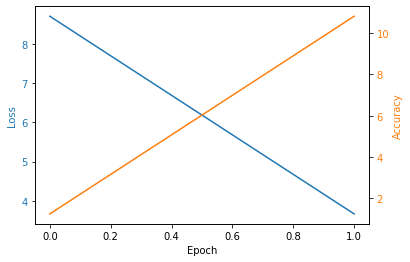

loss: 4.056753  [    0/28000] epoch: 2
loss: 3.815264  [ 1600/28000] epoch: 2
loss: 3.487237  [ 3200/28000] epoch: 2
loss: 3.808142  [ 4800/28000] epoch: 2
loss: 3.759459  [ 6400/28000] epoch: 2
loss: 3.694066  [ 8000/28000] epoch: 2
loss: 3.651486  [ 9600/28000] epoch: 2
loss: 3.718845  [11200/28000] epoch: 2
loss: 3.842450  [12800/28000] epoch: 2


In [ ]:
stats = train_loop(trainloader, valloader, model, criterion, optimizer, scheduler)

In [17]:
stats = train_loop(trainloader, model, criterion, optimizer)
stats.to_csv("stats_densenet.csv")

,epoch,loss,accuracy
0,0,8.700000,1.250000
1,1,1.153709,73.143236
2,2,1.159672,73.441645
3,3,1.177926,73.839523
4,4,1.158152,73.541114


In [18]:
PATH = f'beiter.pth'
torch.save(beit.state_dict(), PATH)

In [32]:
test_results = {"img_name" : [], "label": []}

for file_name, image in tqdm(testloader):
    X = image.to(device)
    pred = beit(X)["logits"].argmax(1)
    
    test_results["img_name"] += file_name
    test_results["label"] += [int(i) for i in pred.cpu()]

100%|████████████████████████████████████████| 479/479 [02:50<00:00,  2.81it/s]


In [33]:
test_df = pd.DataFrame(test_results)

test_df.head()

,img_name,label
0,test_1.jpg,15
1,test_10.jpg,45
2,test_100.jpg,34
3,test_1000.jpg,29
4,test_1001.jpg,10


In [34]:
test_df.to_csv("./submissions/submission_beit_full_training_aug_5_epochs.csv", index=False)